In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pandas as pd
from scipy.io import loadmat

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer

from pyriemann.classification import MDM, FgMDM, TSclassifier
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from mne.decoding import CSP
from tqdm.notebook import trange, tqdm

%matplotlib inline

In [4]:
scoring = 'accuracy' # kappa score

In [5]:
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

def isPD2(B):
    """Returns true when input is positive-definite, via Cholesky"""
    if np.any(np.linalg.eigvals(B) < 0.):
        return False
    else: return True

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

In [56]:
def load_data(feat, subj, idx):
    if feat == "Cov":
        d = loadmat("AlphaBetaTogether/Cov_Training_All.mat", squeeze_me=True)
    else: d = loadmat(feat+"_Training_121280.mat", squeeze_me=True)
    X = np.array(np.transpose(d['Mat'+feat][subj, 0], axes=(2, 0, 1)))
    for i in range(80):
        if not isPD2(X[i]): X[i] = nearestPD(X[i])
    return X[idx]

In [57]:
class FeatConn(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files
    """
    def __init__(self, feat="Cov", subj=0):
        self.feat = feat
        self.subj = subj
    
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        return load_data(self.feat, self.subj, X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [58]:
import numpy

from scipy import stats

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import softmax
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed

from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.distance import distance
from pyriemann.tangentspace import FGDA, TangentSpace

class FgMDM2(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, metric='riemann', tsupdate=False, n_jobs=1):
        """Init."""
        self.metric = metric
        self.n_jobs = n_jobs
        self.tsupdate = tsupdate

        if isinstance(metric, str):
            self.metric_mean = metric

        elif isinstance(metric, dict):
            # check keys
            for key in ['mean', 'distance']:
                if key not in metric.keys():
                    raise KeyError('metric must contain "mean" and "distance"')

            self.metric_mean = metric['mean']

        else:
            raise TypeError('metric must be dict or str')

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self._mdm = MDM(metric=self.metric, n_jobs=self.n_jobs)
        self._fgda = FGDA(metric=self.metric_mean, tsupdate=self.tsupdate)
        cov = self._fgda.fit_transform(X, y)
        self._mdm.fit(cov, y)
        return self

    def predict(self, X):
        cov = self._fgda.transform(X)
        return self._mdm.predict(cov)
    
    def predict_proba(self, X):
        cov = self._fgda.transform(X)
        return self._mdm.predict_proba(cov)
    
    def transform(self, X):
        cov = self._fgda.transform(X)
        return self._mdm.transform(cov)

In [146]:
pipelines = {}
pipelines['fgMDM-Coh'] = make_pipeline(
    FeatConn("Coh", 0),
    FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=1))
pipelines['fgMDM-PLV'] = make_pipeline(
    FeatConn("PLV", 0),
    FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=1))
pipelines['fgMDM-Cov'] = make_pipeline(
    FeatConn("Cov", 0),
    FgMDM2(metric='logeuclid', tsupdate=True, n_jobs=1))

estimators = [('cov', pipelines['fgMDM-Cov']),
              ('coh', pipelines['fgMDM-Coh']),
              ('plv', pipelines['fgMDM-PLV'])]
# final_estimator = LogisticRegression()
final_estimator = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, intercept_scaling=1000., solver='saga')


# Pas terrible...
# final_estimator = GradientBoostingClassifier(random_state=42)
# from sklearn.linear_model import SGDClassifier
# final_estimator = SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=0.1)

cvkf = StratifiedKFold(n_splits=4, shuffle=True)
scl = StackingClassifier(
        estimators=estimators,
        cv = cvkf, n_jobs = 1,
        final_estimator=final_estimator,
        stack_method='predict_proba')

In [147]:
d_ = loadmat("Coh_Training_121280.mat", squeeze_me=True)
y_train_all = []
for i in range(0, 8):
    y_train_all.append(d_['MatCoh'][i, 1])
X = np.array([i for i in range(80)])

all_res = []
for s in range(8):
    y = y_train_all[s]
    le = LabelEncoder()
    y = le.fit_transform(y)

    sc_coh = cross_val_score(pipelines['fgMDM-Coh'], X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    sc_cov = cross_val_score(pipelines['fgMDM-Cov'], X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    sc_plv = cross_val_score(pipelines['fgMDM-PLV'], X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    sc_scl = cross_val_score(scl, X, y, n_jobs=-1,
                             scoring=make_scorer(cohen_kappa_score), 
                             cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1))
    for s_coh, s_cov, s_plv, s_scl in zip(sc_coh, sc_cov, sc_plv, sc_scl):
        res = {'subject': str(s+1),
               'score': s_coh,
               'estimator': "Coh"}
        all_res.append(res)
        res = {'subject': str(s+1),
               'score': s_cov,
               'estimator': "Cov"}
        all_res.append(res)
        res = {'subject': str(s+1),
               'score': s_plv,
               'estimator': "PLV"}
        all_res.append(res)
        res = {'subject': str(s+1),
               'score': s_scl,
               'estimator': "Ensemble"}
        all_res.append(res)
df_strat = pd.DataFrame(all_res)

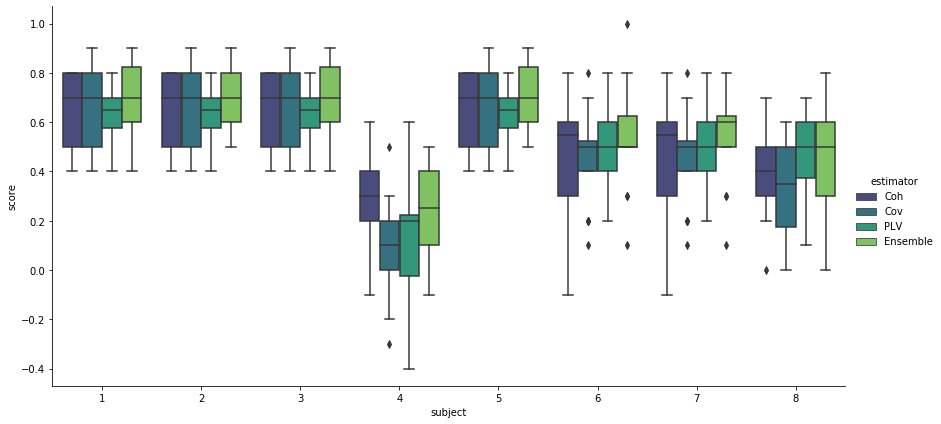

In [148]:
sns.catplot(x='subject', y='score', hue='estimator', kind="box", 
            data=df_strat, palette='viridis', height=6, aspect=2)
plt.savefig("ensemble-subject.png")

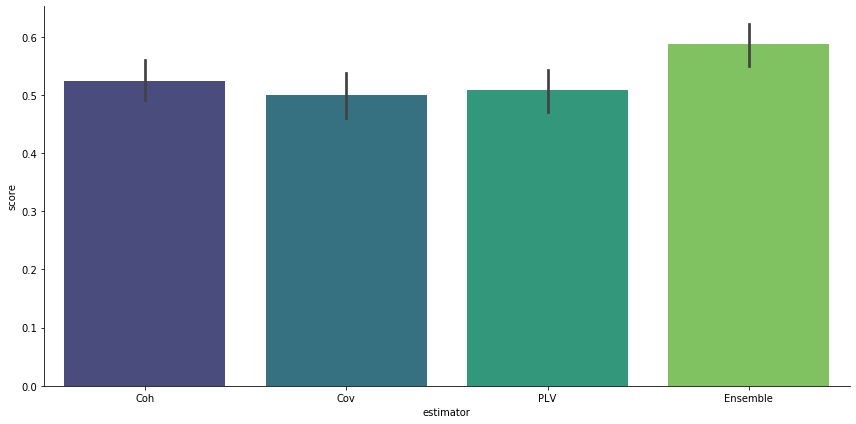

In [149]:
sns.catplot(x='estimator', y='score', kind='bar', data=df_strat, 
            height=6, aspect=2, palette="viridis")
plt.savefig("ensemble-classif.png")

In [151]:
print ("""
Kappa score
===========
FgMDM on coherence        = {:.2f}
FgMDM on Covariance       = {:.2f}
FgMDM on Phase-Lock Value = {:.2f}
---------------------------------
Ensemble classifier       = {:.2f}""".format(
    df_strat[df_strat['estimator'] == 'Coh']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Cov']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'PLV']['score'].to_numpy().mean()*100,
    df_strat[df_strat['estimator'] == 'Ensemble']['score'].to_numpy().mean()*100))


Kappa score
FgMDM on coherence        = 52.44
FgMDM on Covariance       = 50.00
FgMDM on Phase-Lock Value = 50.88
---------------------------------
Ensemble classifier       = 58.69


# Dead code

In [38]:
s = 0
X = np.array([i for i in range(80)])
y = y_train_all[s]
le = LabelEncoder()
y = le.fit_transform(y)
all_res = []

rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1)
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipelines['fgMDM-Coh'].fit(X_train, y_train)
    y_pred = pipelines['fgMDM-Coh'].predict(X_test)
    res = {'subject': str(s),
           'score': cohen_kappa_score(y_pred, y_test),
           'estimator': "Coh"}
    all_res.append(res)
    pipelines['fgMDM-Cov'].fit(X_train, y_train)
    y_pred = pipelines['fgMDM-Cov'].predict(X_test)
    res = {'subject': str(s),
           'score': cohen_kappa_score(y_pred, y_test),
           'estimator': "Cov"}
    all_res.append(res)
    pipelines['fgMDM-PLV'].fit(X_train, y_train)
    y_pred = pipelines['fgMDM-PLV'].predict(X_test)
    res = {'subject': str(s),
           'score': cohen_kappa_score(y_pred, y_test),
           'estimator': "PLV"}
    all_res.append(res)
df_s0 = pd.DataFrame(all_res)